<a href="https://colab.research.google.com/github/sree-vg/DS_Clickstream-customer-conversion/blob/main/My_Zoom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My Zoom: A Transformer-Based Model for Contextual Feedback Validation



In [1]:
!pip uninstall -y transformers accelerate evaluate


Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0


In [2]:
!pip install -q transformers==4.41.2 accelerate==0.31.0 evaluate==0.4.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 74.0 MB/s eta 0:00:00


In [3]:
!pip uninstall -y transformers accelerate evaluate


Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
Found existing installation: accelerate 0.31.0
Uninstalling accelerate-0.31.0:
  Successfully uninstalled accelerate-0.31.0
Found existing installation: evaluate 0.4.3
Uninstalling evaluate-0.4.3:
  Successfully uninstalled evaluate-0.4.3


In [4]:
!pip install -U transformers accelerate evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1


In [5]:
import torch
from transformers import Trainer, AutoTokenizer, AutoModelForSequenceClassification
import accelerate

print("Torch:", torch.__version__)
print("Transformers:", __import__("transformers").__version__)
print("Accelerate:", accelerate.__version__)
print("GPU available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Torch: 2.9.0+cu126
Transformers: 4.57.3
Accelerate: 1.12.0
GPU available: True
GPU: Tesla T4


In [6]:
import pandas as pd
import numpy as np
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
print("Torch:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")



Torch: 2.9.0+cu126
GPU available: True
GPU: Tesla T4


In [7]:
from google.colab import files
uploaded = files.upload()


Saving evaluation.xlsx to evaluation.xlsx
Saving train.xlsx to train.xlsx


In [8]:
train_df = pd.read_excel("train.xlsx")
eval_df  = pd.read_excel("evaluation.xlsx")

print(train_df.shape)
print(eval_df.shape)

train_df.head()


(2061, 3)
(9000, 3)


,text,reason,label
0,this is an amazing app for online classes!but,good app for conducting online classes,1
1,very practical and easy to use,app is user-friendly,1
2,this app is very good for video conferencing.,good for video conferencing,1
3,i can not download this zoom app,unable to download zoom app,1
4,i am not able to download this app,want to download the app,1


In [9]:
print(train_df.columns)


Index(['text', 'reason', 'label'], dtype='object')


In [10]:
train_df.rename(columns={
    "Text": "text",
    "Reason": "reason",
    "Label": "label"
}, inplace=True)

eval_df.rename(columns={
    "Text": "text",
    "Reason": "reason",
    "Label": "label"
}, inplace=True)


In [11]:
print("Train missing values:\n", train_df.isnull().sum())
print("\nEval missing values:\n", eval_df.isnull().sum())

Train missing values:
 text      0
reason    0
label     0
dtype: int64

Eval missing values:
 text      0
reason    0
label     0
dtype: int64


In [12]:
train_df = train_df.dropna()
eval_df = eval_df.dropna()


In [13]:
train_df.isnull().sum()
eval_df.isnull().sum()

,0
text,0
reason,0
label,0


In [14]:
negative_df = train_df.copy()

negative_df["reason"] = negative_df["reason"].sample(
    frac=1, random_state=42
).values

# Set label = 0 for mismatched pairs
negative_df["label"] = 0

negative_df = negative_df[
    negative_df["text"] != negative_df["reason"]
]

print("Negative samples created:", negative_df.shape)


Negative samples created: (2061, 3)


In [15]:
train_df = pd.concat([train_df, negative_df], ignore_index=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Final training label distribution:")
print(train_df["label"].value_counts(normalize=True))


Final training label distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [16]:
# Label meaning:
# 1 → Aligned feedback
# 0 → Not aligned feedback

print("Train label distribution:")
print(train_df["label"].value_counts(normalize=True))

print("\nEval label distribution:")
print(eval_df["label"].value_counts(normalize=True))


Train label distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Eval label distribution:
label
0    0.666556
1    0.333444
Name: proportion, dtype: float64


In [17]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
eval_dataset  = Dataset.from_pandas(eval_df)

print(train_dataset)
print(eval_dataset)


Dataset({
    features: ['text', 'reason', 'label'],
    num_rows: 4122
})
Dataset({
    features: ['text', 'reason', 'label'],
    num_rows: 9000
})


In [18]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        example["reason"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset  = eval_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/4122 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [20]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

eval_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

model.config.problem_type = "single_label_classification"


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    accuracy = accuracy_score(labels, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [23]:
import evaluate

accuracy = evaluate.load("accuracy")

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",

    learning_rate=2e-5,

    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,

    num_train_epochs=3,

    weight_decay=0.01,

    logging_steps=50,
    logging_dir="./logs",

    load_best_model_at_end=True,
    metric_for_best_model="f1",

    fp16=True,
    dataloader_num_workers=2,

    report_to="none"
)


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [27]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=train_df["label"]
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-887494177.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.181300,1.278984,0.636444,0.746186,0.636444,0.642681
2,0.089700,1.974725,0.556556,0.755039,0.556556,0.544428
3,0.055000,1.762008,0.612444,0.754858,0.612444,0.614018


TrainOutput(global_step=387, training_loss=0.14286206181351221, metrics={'train_runtime': 165.602, 'train_samples_per_second': 74.673, 'train_steps_per_second': 2.337, 'total_flos': 813407827645440.0, 'train_loss': 0.14286206181351221, 'epoch': 3.0})

In [30]:
results = trainer.evaluate()
print(results)


{'eval_loss': 1.2789843082427979, 'eval_accuracy': 0.6364444444444445, 'eval_precision': 0.7461858291671449, 'eval_recall': 0.6364444444444445, 'eval_f1': 0.6426811438308309, 'eval_runtime': 14.4699, 'eval_samples_per_second': 621.981, 'eval_steps_per_second': 19.489, 'epoch': 3.0}


In [31]:
# Save best model and tokenizer for deployment
trainer.save_model("./zoom_feedback_model")
tokenizer.save_pretrained("./zoom_feedback_model")

('./zoom_feedback_model/tokenizer_config.json',
 './zoom_feedback_model/special_tokens_map.json',
 './zoom_feedback_model/vocab.txt',
 './zoom_feedback_model/added_tokens.json',
 './zoom_feedback_model/tokenizer.json')

In [32]:
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    "zoom_feedback_model",
    local_files_only=True
).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    "zoom_feedback_model",
    local_files_only=True
)

model.eval()

def classify_feedback(feedback, reason):
    inputs = tokenizer(
        feedback,
        reason,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)

    pred = torch.argmax(probs).item()
    confidence = probs[0][pred].item()


    return "Aligned ✅" if pred == 1 else "Not Aligned ❌", round(confidence, 3)

interface = gr.Interface(
    fn=classify_feedback,
    inputs=[
        gr.Textbox(label="User Feedback"),
        gr.Textbox(label="Dropdown Reason")
    ],
    outputs=[
        gr.Text(label="Prediction"),
        gr.Number(label="Confidence")
    ],
    title="My Zoom – Feedback Validator",
    description="Validate whether feedback aligns with selected reason"
)

interface.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://89f395de8ab51f952f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
# Inference function
def predict_alignment(text, reason):
    model.eval()

    inputs = tokenizer(
        text,
        reason,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)

    pred_label = torch.argmax(probs).item()
    confidence = probs[0][pred_label].item()

    if confidence < 0.6:
        return "Uncertain ⚠️", round(confidence, 3)

    return "Aligned ✅" if pred_label == 1 else "Not Aligned ❌", round(confidence, 3)


In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix

predictions = trainer.predict(eval_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(cm)


[[3149 2850]
 [ 422 2579]]


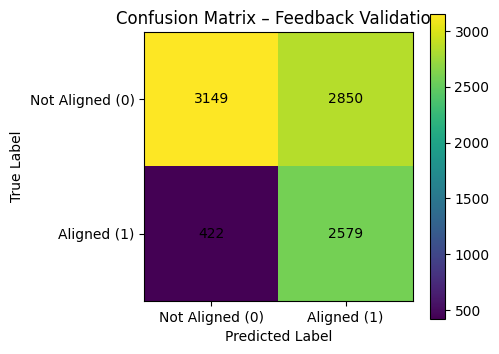

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix – Feedback Validation")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
classes = ["Not Aligned (0)", "Aligned (1)"]
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")

plt.tight_layout()
plt.show()



In [36]:
cm = confusion_matrix(y_true, y_pred)
print(cm)
# Error analysis
eval_df["prediction"] = y_pred
eval_df["correct"] = eval_df["label"] == eval_df["prediction"]

print("Sample misclassified rows:")
eval_df[~eval_df["correct"]].head(10)


[[3149 2850]
 [ 422 2579]]
Sample misclassified rows:


,text,reason,label,prediction,correct
2,very helpful when and home working remotley,good app for work,0,1,False
3,this zoom so called and missed call and mobile...,receiving incorrect phone number message,0,1,False
4,one of my favorite apps,good for spending time,0,1,False
9,"also, i can continue watching where i left off.",unable to sync watched episodes,0,1,False
15,her zoom is useful for home school or meetings...,good app for students,1,0,False
17,watching on tv can have its moments where ads ...,getting ads frequently,0,1,False
18,its good for meetings,good app for conducting online meeting,0,1,False
20,"the app works well, i use it to talk to friend...",good for family and friends,0,1,False
22,"sensational, it is disney",app is good to watch disney content,0,1,False
23,family guy is my life thank you disney+ and ev...,good for watching movies and serials,0,1,False
